In [63]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import entropy

from sklearn.svm import LinearSVC
from sktree.stats import build_oob_forest
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sktree.ensemble import HonestForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

# import seaborn as sns
import pandas as pd
import warnings
import string
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [64]:

def make_trunk_classification(
    n_samples,
    n_dim=4096,
    n_informative=1,
    simulation: str = "trunk",
    mu_0: float = 0,
    mu_1: float = 1,
    rho: int = 0,
    band_type: str = "ma",
    return_params: bool = False,
    mix: float = 0.5,
    seed=None,
):
    if n_dim < n_informative:
        raise ValueError(
            f"Number of informative dimensions {n_informative} must be less than number "
            f"of dimensions, {n_dim}"
        )
    rng = np.random.default_rng(seed=seed)
    rng1 = np.random.default_rng(seed=seed)
    mu_0 = np.array([mu_0 / np.sqrt(i) for i in range(1, n_informative + 1)])
    mu_1 = np.array([mu_1 / np.sqrt(i) for i in range(1, n_informative + 1)])
    if rho != 0:
        if band_type == "ma":
            cov = _moving_avg_cov(n_informative, rho)
        elif band_type == "ar":
            cov = _autoregressive_cov(n_informative, rho)
        else:
            raise ValueError(f'Band type {band_type} must be one of "ma", or "ar".')
    else:
        cov = np.identity(n_informative)
    if mix < 0 or mix > 1:
        raise ValueError("Mix must be between 0 and 1.")
    # speed up computations for large multivariate normal matrix with SVD approximation
    if n_informative > 1000:
        method = "cholesky"
    else:
        method = "svd"
    if simulation == "trunk":
        X = np.vstack(
            (
                rng.multivariate_normal(mu_0, cov, n_samples // 2, method=method),
                rng1.multivariate_normal(mu_1, cov, n_samples // 2, method=method),
            )
        )
    elif simulation == "trunk_overlap":
        mixture_idx = rng.choice(
            2, n_samples // 2, replace=True, shuffle=True, p=[mix, 1 - mix]
        )
        norm_params = [[mu_0, cov], [mu_1, cov]]
        X_mixture = np.fromiter(
            (
                rng.multivariate_normal(*(norm_params[i]), size=1, method=method)
                for i in mixture_idx
            ),
            dtype=np.dtype((float, n_informative)),
        )
        X_mixture_2 = np.fromiter(
            (
                rng1.multivariate_normal(*(norm_params[i]), size=1, method=method)
                for i in mixture_idx
            ),
            dtype=np.dtype((float, n_informative)),
        )
        X = np.vstack(
            (
                X_mixture.reshape(n_samples // 2, n_informative),
                X_mixture_2.reshape(n_samples // 2, n_informative),
            )
        )
    elif simulation == "trunk_mix":
        mixture_idx = rng.choice(
            2, n_samples // 2, replace=True, shuffle=True, p=[mix, 1 - mix]
        )
        norm_params = [[mu_0, cov], [mu_1, cov]]
        X_mixture = np.fromiter(
            (
                rng1.multivariate_normal(*(norm_params[i]), size=1, method=method)
                for i in mixture_idx
            ),
            dtype=np.dtype((float, n_informative)),
        )
        X = np.vstack(
            (
                rng.multivariate_normal(
                    np.zeros(n_informative), cov, n_samples // 2, method=method
                ),
                X_mixture.reshape(n_samples // 2, n_informative),
            )
        )
    else:
        raise ValueError(f"Simulation must be: trunk, trunk_overlap, trunk_mix")
    if n_dim > n_informative:
        X = np.hstack(
            (X, rng.normal(loc=0, scale=1, size=(X.shape[0], n_dim - n_informative)))
        )
    y = np.concatenate((np.zeros(n_samples // 2), np.ones(n_samples // 2)))
    if return_params:
        returns = [X, y]
        if simulation == "trunk":
            returns += [[mu_0, mu_1], [cov, cov]]
        elif simulation == "trunk-overlap":
            returns += [[np.zeros(n_informative), np.zeros(n_informative)], [cov, cov]]
        elif simulation == "trunk-mix":
            returns += [*list(zip(*norm_params)), X_mixture]
        return returns
    return X, y

In [65]:
def make_simulation(name="linear", seed=23, sample_size=256, n_jobs=-5):
    if name == "linear":
        X, y = make_trunk_classification(
            n_samples=sample_size,
            n_dim=4096,
            simulation="trunk",
            n_informative=1,
            seed=seed,
        )
    elif name == "nonlinear":
        X, y = make_trunk_classification(
            n_samples=sample_size,
            n_dim=4096,
            simulation="trunk_mix",
            mu_0=0,
            mu_1=5,
            mix=0.75,
            n_informative=1,
            seed=seed,
        )
    else:
        X, y = make_trunk_classification(
            n_samples=sample_size,
            n_dim=4096,
            simulation="trunk_overlap",
            mu_0=0,
            mu_1=5,
            mix=0.75,
            n_informative=1,
            seed=seed,
        )

        train_samples = 256  # Samples used for training the models
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            shuffle=True,
            stratify=y,
            # test_size=100000 - train_samples,
        )

        lr = LogisticRegressionCV(
            Cs=np.logspace(-6, 6, 101), cv=10, scoring="neg_log_loss", max_iter=1_000
        )
    lr = LogisticRegression(
        penalty="l1", solver="liblinear", n_jobs=n_jobs, random_state=seed
    )
    gnb = GaussianNB()
    #     svc = NaivelyCalibratedLinearSVC(C=1.0)
    svc = SVC(probability=True, kernel="rbf", random_state=seed)
    rfc = RandomForestClassifier(
        n_estimators=6000, max_features=0.3, n_jobs=n_jobs, random_state=seed
    )
    might = HonestForestClassifier(
        n_estimators=6000,
        max_samples=1.6,
        max_features=0.3,
        bootstrap=True,
        stratify=True,
        random_state=seed,
        n_jobs=n_jobs,
    )

    clf_list = [
        (might, "MIGHT"),
        # (rfc, "Random Forest"),
        # (svc, "SVM"),
        # (gnb, "Naive Bayes"),
        # (lr, "Logistic Regression"),
    ]

    fpr_s = []
    tpr_s = []
    for i, (clf, name) in enumerate(clf_list):
        if name == "MIGHT":
            _, observe_proba = build_oob_forest(clf, X, y)
            observe_proba = np.nanmean(observe_proba, axis=0)
            fpr, tpr, thresholds = roc_curve(
                y, observe_proba[:, 1], pos_label=1, drop_intermediate=False
            )
        else:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, shuffle=True, stratify=y, test_size=0.2
            )

            X_fit, X_cal, y_fit, y_cal = train_test_split(
                X_train, y_train, test_size=0.5, stratify=y_train
            )
            clf.fit(X_fit, y_fit)

            if sample_size <= 1024:
                calibrated_model = CalibratedClassifierCV(
                    clf, cv="prefit", method="sigmoid"
                )
            else:
                calibrated_model = CalibratedClassifierCV(
                    clf, cv="prefit", method="isotonic"
                )
            calibrated_model.fit(X_cal, y_cal)
            posterior = calibrated_model.predict_proba(X_test)

            fpr, tpr, thresholds = roc_curve(
                y_test,
                posterior[:, 1],
                pos_label=1,
                drop_intermediate=False,
            )
        fpr_s.append(fpr)
        tpr_s.append(tpr)

    return clf_list, fpr_s, tpr_s

In [54]:
import pickle
from tqdm import tqdm

clf_linear_s = []
fpr_linear_s = []
tpr_linear_s = []

clf_nonlinear_s = []
fpr_nonlinear_s = []
tpr_nonlinear_s = []

clf_null_s = []
fpr_null_s = []
tpr_null_s = []

N_ITR = 100
N_JOBS = -5
DIRECTORY = "./"

for i in tqdm(range(N_ITR)):
    #     print(i)
    clf_linear, fpr_linear, tpr_linear = make_simulation("linear", seed=i)
    clf_linear_s.append(clf_linear)
    fpr_linear_s.append(fpr_linear)
    tpr_linear_s.append(tpr_linear)

    #     print("non")
    clf_nonlinear, fpr_nonlinear, tpr_nonlinear = make_simulation("nonlinear", seed=i)
    clf_nonlinear_s.append(clf_nonlinear)
    fpr_nonlinear_s.append(fpr_nonlinear)
    tpr_nonlinear_s.append(tpr_nonlinear)

    #     print("null")
    clf_null, fpr_null, tpr_null = make_simulation("null", seed=i)
    clf_null_s.append(clf_null)
    fpr_null_s.append(fpr_null)
    tpr_null_s.append(tpr_null)

    with open(DIRECTORY + "fpr_linear_s.pkl", "wb") as f:
        pickle.dump(fpr_linear_s, f)

    with open(DIRECTORY + "tpr_linear_s.pkl", "wb") as f:
        pickle.dump(tpr_linear_s, f)

    with open(DIRECTORY + "fpr_nonlinear_s.pkl", "wb") as f:
        pickle.dump(fpr_nonlinear_s, f)

    with open(DIRECTORY + "tpr_nonlinear_s.pkl", "wb") as f:
        pickle.dump(tpr_nonlinear_s, f)

    with open(DIRECTORY + "fpr_null_s.pkl", "wb") as f:
        pickle.dump(fpr_null_s, f)

    with open(DIRECTORY + "tpr_null_s.pkl", "wb") as f:
        pickle.dump(tpr_null_s, f)

    with open(DIRECTORY + "clf_linear_s.pkl", "wb") as f:
        pickle.dump(clf_linear_s, f)

    with open(DIRECTORY + "clf_nonlinear_s.pkl", "wb") as f:
        pickle.dump(clf_nonlinear_s, f)

    with open(DIRECTORY + "clf_null_s.pkl", "wb") as f:
        pickle.dump(clf_null_s, f)



100%|██████████| 100/100 [2:09:49<00:00, 77.90s/it]  


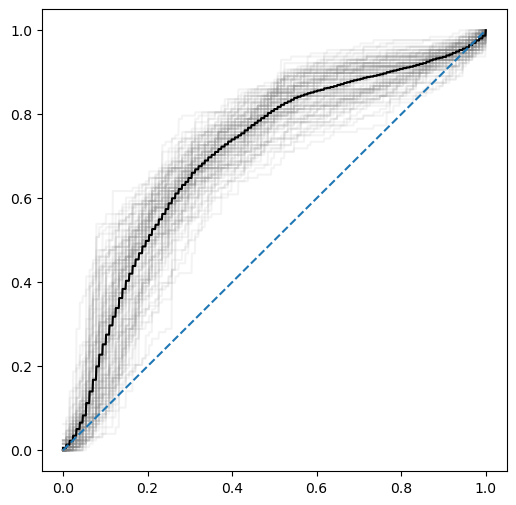

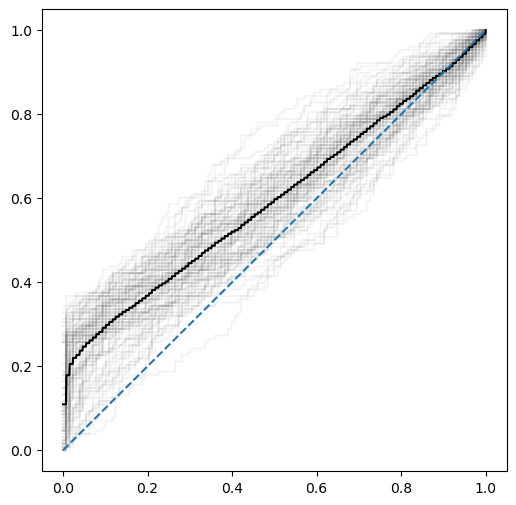

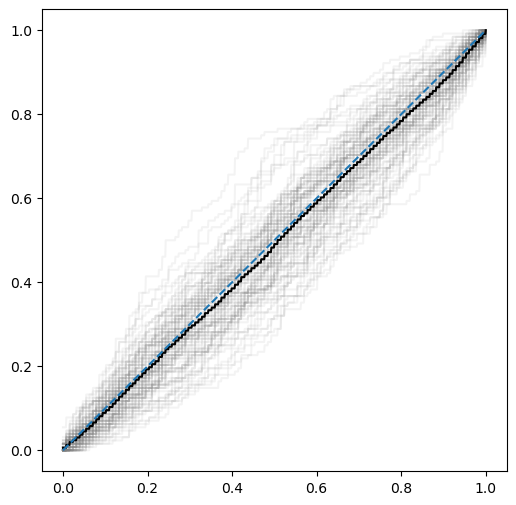

In [74]:
fpr_list = [fpr_linear_s, fpr_nonlinear_s, fpr_null_s]
tpr_list = [tpr_linear_s, tpr_nonlinear_s, tpr_null_s]
names = ["linear", "nonlinear", "null"]
for fpr_ls, tpr_ls, name in zip(fpr_list, tpr_list, names):
    tpr_s = []
    for i in range(N_ITR):
        tpr = np.interp(base_fpr, fpr_ls[i][0], tpr_ls[i][0])
        tpr_s.append(tpr)

    # tpr_s = np.mean(tpr_s, axis=0)
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    for i in range(N_ITR):
        ax.plot(base_fpr, tpr_s[i], alpha=0.09, color="gray")
    ax.plot(base_fpr, np.mean(tpr_s, axis=0), color="black", label="Null")
    ax.plot([0,1], [0,1], "--")

In [14]:
fpr_ls = []
tpr_ls = []
proba_ls = []
y_ls = []
sample_size = 256
n_estimators = 1000
# N_ITR = 10
for i in range(N_ITR):
    X, y = make_trunk_classification(
        n_samples=sample_size,
        n_dim=4096,
        simulation="trunk_overlap",
        mu_0=0,
        mu_1=0,
        mix=0.75,
        n_informative=1,
        seed=i+123,
    )
    # shuffle y
    y = np.random.permutation(y)
    y_ls.append(y)
    
    might_1 = HonestForestClassifier(
        n_estimators=n_estimators,
        max_samples=1.6,
        max_features=0.3,
        bootstrap=True,
        stratify=True,
        random_state=i+123,
        n_jobs=-5,
    )

    might_1, observe_proba_ = build_oob_forest(might_1, X, y)
    observe_proba = np.nanmean(observe_proba_, axis=0)

    fpr, tpr, thresholds = roc_curve(
        y, observe_proba[:, 1], pos_label=1, drop_intermediate=False
    )
    fpr_ls.append(fpr)
    tpr_ls.append(tpr)
    proba_ls.append(observe_proba)

t-statistic: 2.4075833196474976, p-value: 0.016065526319793508


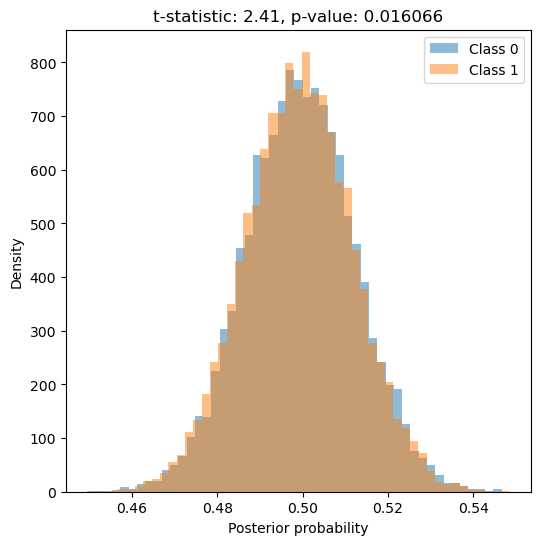

In [16]:
# stack the first and second dimension
proba_ls = np.array(proba_ls)
proba_ls_ = proba_ls.reshape(proba_ls.shape[0]*proba_ls.shape[1], proba_ls.shape[2])
# stack y in one list
y_ls_= np.array(y_ls).reshape(-1).squeeze()

posterior_0 = proba_ls_[y_ls_==0, 1]
posterior_1 = proba_ls_[y_ls_==1, 1]
# conduct a two-sample t-test
from matplotlib.pylab import sample
from scipy.stats import ttest_ind
t, p = ttest_ind(posterior_0, posterior_1)
print(f"t-statistic: {t}, p-value: {p}")
# plot the posterior distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(posterior_0, bins=50, alpha=0.5, label="Class 0")
ax.hist(posterior_1,  bins=50, alpha=0.5, label="Class 1")
ax.legend()
ax.set_xlabel("Posterior probability")
ax.set_ylabel("Density")
ax.set_title("t-statistic: {:.2f}, p-value: {:.6f}".format(t, p))
# save the figure
plt.savefig(f"posterior_distribution_{sample_size}_{n_estimators}.png")
plt.show()

In [17]:
# conduct a two-sample t-test
from scipy.stats import ttest_ind
t, p = ttest_ind(posterior_0, posterior_1)
print(f"t-statistic: {t}, p-value: {p}")


t-statistic: 2.4075833196474976, p-value: 0.016065526319793508


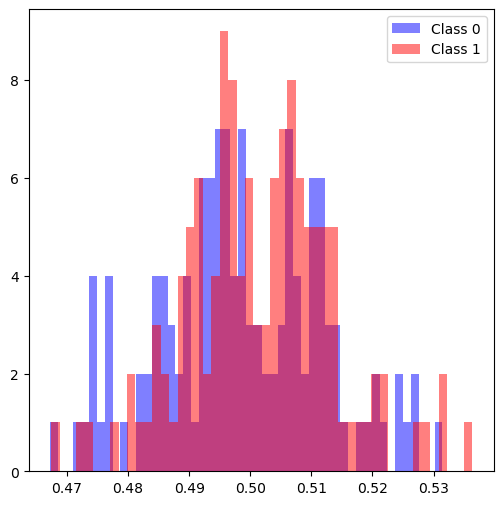

In [21]:
# plot the histogram of the probabilities for the two classes colored by the true class
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(observe_proba[y==0, 1], bins=50, alpha=0.5, label="Class 0", color="blue")
ax.hist(observe_proba[y==1, 1], bins=50, alpha=0.5, label="Class 1", color="red")
ax.legend()
plt.show()

In [19]:
observe_proba[y==0, 1].mean(), observe_proba[y==1, 1].mean()

(0.4985084320565557, 0.5015278930492864)

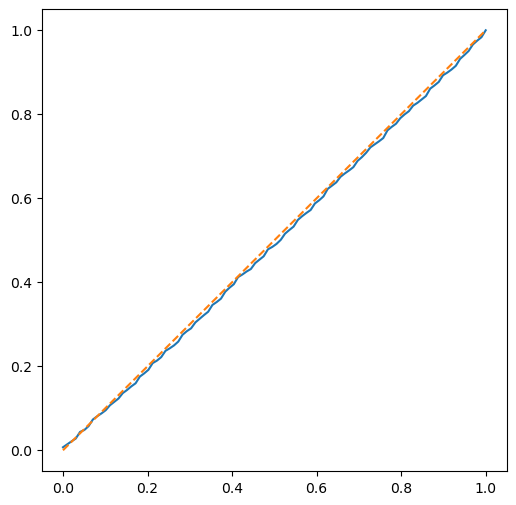

In [22]:
base_fpr = np.linspace(0, 1, 100)
# N_ITR = 1
tpr_s = []
for i in range(N_ITR):
    tpr = np.interp(base_fpr, fpr_ls[i], tpr_ls[i])
    tpr_s.append(tpr)

tpr_s = np.mean(tpr_s, axis=0)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(base_fpr, tpr_s)
ax.plot([0,1], [0,1], "--")

(102124,)
(102597,)
(51279,)
127.69407778778739 127.37536185268576 127.36285809005636
127.69407778778739 127.37536185268576 127.36285809005636


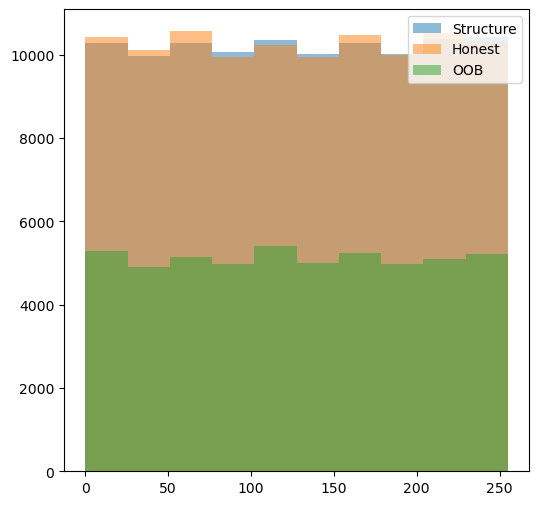

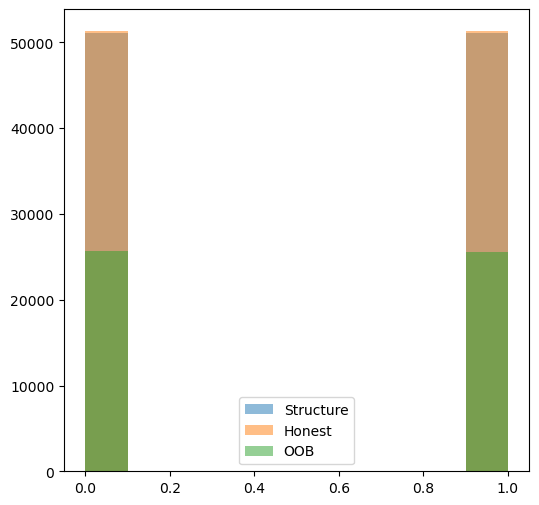

In [23]:
# get the list of the indices of the structure and honest samples
might_1.structure_indices_
# make it into a 1D array
structure_indices = [idx for indices in might_1.structure_indices_ for idx in indices]
structure_indices = np.array(structure_indices)
print(structure_indices.shape)
honest_indices = [idx for indices in might_1.honest_indices_ for idx in indices]
honest_indices = np.array(honest_indices)
print(honest_indices.shape)
oob_samples = [idx for indices in might_1.oob_samples_ for idx in indices]
oob_samples = np.array(oob_samples)
print(oob_samples.shape)
# might_1.honest_indices_
# might_1.oob_samples_
bins = None
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(structure_indices, bins=bins, alpha=0.5, label="Structure")
ax.hist(honest_indices, bins=bins, alpha=0.5, label="Honest")
ax.hist(oob_samples, bins=bins, alpha=0.5, label="OOB")
ax.legend()
print(np.mean(structure_indices), np.mean(honest_indices), np.mean(oob_samples))


fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(y[structure_indices], bins=bins, alpha=0.5, label="Structure")
ax.hist(y[honest_indices], bins=bins, alpha=0.5, label="Honest")
ax.hist(y[oob_samples], bins=bins, alpha=0.5, label="OOB")
ax.legend()
print(np.mean(structure_indices), np.mean(honest_indices), np.mean(oob_samples))
